In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages    # Reducer to append the previous communication back to State.
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [ ]:
import os
from dotenv import load_dotenv

load_dotenv()
OPENAI_KEY =  os.getenv("OPENAI_API_KEY")

In [11]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o-mini",
    api_key=OPENAI_KEY,
    temperature=0.4,
    streaming=False,
)
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000001715D85F380>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000001715D85F320>, root_client=<openai.OpenAI object at 0x000001715D546570>, root_async_client=<openai.AsyncOpenAI object at 0x000001715D8576E0>, model_name='gpt-4o-mini', temperature=0.4, model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True)

### Here creating the agentic architecture (Can extend in future)

In [12]:
# Chat Agent:
def smartBot(state: State):
    return {'messages': [llm.invoke(state['messages'])]}

In [13]:
# Build a graph
graph_builder = StateGraph(State)
graph_builder.add_node("smartBot", smartBot)

graph_builder.add_edge(START, "smartBot")
graph_builder.add_edge("smartBot", END)

graph = graph_builder.compile()

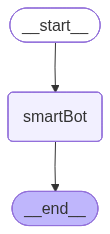

In [14]:
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e) 

In [19]:
a = ["  January", " February", "    March", "    April", "      May", "     June", "     July", "   August", 
                           "September", "  October", " November", " December"]
print([itm.upper() for itm in a])

['  JANUARY', ' FEBRUARY', '    MARCH', '    APRIL', '      MAY', '     JUNE', '     JULY', '   AUGUST', 'SEPTEMBER', '  OCTOBER', ' NOVEMBER', ' DECEMBER']


In [21]:
from datetime import date, timedelta

In [35]:
def get_first_date_of_financial_year(year):
    d = date(year - 1, 12, 31)          # Dec 31 of previous year
    print(d.weekday())
    offset = (d.weekday() - 3) % 7      # Thursday = 3 (Mon=0..Sun=6)
    return d - timedelta(days=offset)

def get_second_last_date_of_financial_year(year):
    d = date(year, 12, 31)                    # Dec 31 of the same year
    last_thu = d - timedelta(days=(d.weekday() - 3) % 7)  # last Thursday
    return last_thu - timedelta(days=7)       # second-to-last Thursday

# Todo convert to a function to add the indentation.
# months_with_indentation = ['  JANUARY', ' FEBRUARY', '    MARCH', '    APRIL', '      MAY', '     JUNE', '     JULY', '   AUGUST', 
#                            'SEPTEMBER', '  OCTOBER', ' NOVEMBER', ' DECEMBER']

months_with_indentation = {1: '  JANUARY', 2: ' FEBRUARY', 3: '    MARCH', 4: '    APRIL',
 5: '      MAY', 6: '     JUNE', 7: '     JULY', 8: '   AUGUST',
 9: 'SEPTEMBER', 10: '  OCTOBER', 11: ' NOVEMBER', 12: ' DECEMBER'}



In [48]:
first_date = get_first_date_of_financial_year(2025)
last_date = get_second_last_date_of_financial_year(2025)
day_before_first_day = first_date - timedelta(days=7)
print(first_date, last_date, day_before_first_day)

1
2024-12-26 2025-12-18 2024-12-19


In [ ]:
from pydantic import BaseModel

class RowData(BaseModel):
    month: int
    day: str
    year: str
    prev_month: int
    prev_day: str
    prev_year: str
    week: str
    prevJulday: str
    curJulday: str
    isFirstWeek: bool
    isLastWeek: bool
    

In [69]:
from datetime import timedelta

curr = first_date
week = 1  # start at 1 (not 01)
rows: list[RowData] = []

while curr <= last_date:
    prev = curr - timedelta(days=7)

    row = RowData(
        month=curr.month,
        day=f"{curr.day:02d}",
        year=str(curr.year),

        prev_month=prev.month,
        prev_day=f"{prev.day:02d}",
        prev_year=str(prev.year),

        week=f"{week:02d}",
        prevJulday=f"{prev.timetuple().tm_yday:03d}",
        curJulday=f"{curr.timetuple().tm_yday:03d}",

        isFirstWeek= False,
        isLastWeek= False,
    )
    rows.append(row)

    # (optional) print row summary
    # print(curr.isoformat(), f"Week {week:02d}", "DOY", row.curJulday)

    curr += timedelta(days=7)
    week += 1

# print(rows[:2])


In [68]:
from pathlib import Path
lst_str = []

for row in rows:
    s = []
    s.append(months_with_indentation[row.month])
    s.append(" ")
    s.append(str(row.day))
    s.append(" ")
    s.append(str(row.year))
    s.append(" "*2)
    s.append(str(row.week))
    s.append(" "*2)
    s.append("XXX") # Todo need to change
    s.append(" "*22)
    s.append(str(row.prev_year))
    s.append(str(row.prevJulday))
    s.append(str(row.year))
    s.append(str(row.curJulday))
    s.append(" "*2)
    s.append(str(row.prev_year))
    s.append(f"{row.prev_month:02d}")
    # s.append(str(row.prev_month))
    s.append(str(row.prev_day))
    s.append(str(row.year))
    # s.append(str(row.month))
    s.append(str(row.day))
    s.append(f"{row.month:02d}")
    
    
    lst_str.append("".join(s))
print(lst_str)

out_path = Path("financial_year_output.txt")
out_path.write_text("\n".join(lst_str) + "\n", encoding="utf-8")
print(f"Saved {len(lst_str)} lines to {out_path.resolve()}")

[' DECEMBER 26 2024  01  XXX                      20243542024361  2024121920242612', '  JANUARY 02 2025  02  XXX                      20243612025002  2024122620250201', '  JANUARY 09 2025  03  XXX                      20250022025009  2025010220250901', '  JANUARY 16 2025  04  XXX                      20250092025016  2025010920251601', '  JANUARY 23 2025  05  XXX                      20250162025023  2025011620252301', '  JANUARY 30 2025  06  XXX                      20250232025030  2025012320253001', ' FEBRUARY 06 2025  07  XXX                      20250302025037  2025013020250602', ' FEBRUARY 13 2025  08  XXX                      20250372025044  2025020620251302', ' FEBRUARY 20 2025  09  XXX                      20250442025051  2025021320252002', ' FEBRUARY 27 2025  10  XXX                      20250512025058  2025022020252702', '    MARCH 06 2025  11  XXX                      20250582025065  2025022720250603', '    MARCH 13 2025  12  XXX                      20250652025072  2025030620

In [3]:
from datetime import date, timedelta
from pydantic import BaseModel
from datetime import timedelta
from pathlib import Path

def get_first_date_of_financial_year(year):
    d = date(year - 1, 12, 31)          # Dec 31 of previous year
    print(d.weekday())
    offset = (d.weekday() - 3) % 7      # Thursday = 3 (Mon=0..Sun=6)
    return d - timedelta(days=offset)

def get_second_last_date_of_financial_year(year):
    d = date(year, 12, 31)                    # Dec 31 of the same year
    last_thu = d - timedelta(days=(d.weekday() - 3) % 7)  # last Thursday
    return last_thu - timedelta(days=7)       # second-to-last Thursday

months_with_indentation = {1: '  JANUARY', 2: ' FEBRUARY', 3: '    MARCH', 4: '    APRIL',
 5: '      MAY', 6: '     JUNE', 7: '     JULY', 8: '   AUGUST',
 9: 'SEPTEMBER', 10: '  OCTOBER', 11: ' NOVEMBER', 12: ' DECEMBER'}


class RowData(BaseModel):
    month: int
    day: str
    year: str
    prev_month: int
    prev_day: str
    prev_year: str
    week: str
    prevJulday: str
    curJulday: str
    isFirstWeekOfMonth: bool = False
    isLastWeekOfMonth: bool = False
    financialYearMonth: int = 0
    
def row_data_for_file(year):
    first_date = get_first_date_of_financial_year(year)
    last_date = get_second_last_date_of_financial_year(year)
    day_before_first_day = first_date - timedelta(days=7)
    curr = first_date
    week = 1  # start at 1 (not 01)
    rows: list[RowData] = []
    
    while curr <= last_date:
        prev = curr - timedelta(days=7)
        isFirstWeekOfMonth = False
        # First financial year week will be previous year last week in december.
        if rows == []:
            # Last week of December, but first week of Financial month
            isFirstWeekOfMonth = True
            print("empty call")
        # New month (when previous month is different from current month)
        # but not January (which is financial month 1)
        elif curr.month != rows[-1].month and curr.month != 1:
            isFirstWeekOfMonth = True
            rows[-1].isLastWeekOfMonth = True
        
        financialYearMonth = 0
        if curr.month == 12 and curr.year == year-1:
            financialYearMonth = 1
        else:
            financialYearMonth = curr.month

        row = RowData(
            month=curr.month,
            day=f"{curr.day:02d}",
            year=str(curr.year),

            prev_month=prev.month,
            prev_day=f"{prev.day:02d}",
            prev_year=str(prev.year),

            week=f"{week:02d}",
            prevJulday=f"{prev.timetuple().tm_yday:03d}",
            curJulday=f"{curr.timetuple().tm_yday:03d}",
            
            isFirstWeekOfMonth= isFirstWeekOfMonth,
            isLastWeekOfMonth= False,
            financialYearMonth= financialYearMonth,
        )
        rows.append(row)
        curr += timedelta(days=7)
        week += 1
    
    for r in rows:
        print(r)
    return rows
    
    
tmp = row_data_for_file(2024)

6
empty call
month=12 day='28' year='2023' prev_month=12 prev_day='21' prev_year='2023' week='01' prevJulday='355' curJulday='362' isFirstWeekOfMonth=True isLastWeekOfMonth=False financialYearMonth=1
month=1 day='04' year='2024' prev_month=12 prev_day='28' prev_year='2023' week='02' prevJulday='362' curJulday='004' isFirstWeekOfMonth=False isLastWeekOfMonth=False financialYearMonth=1
month=1 day='11' year='2024' prev_month=1 prev_day='04' prev_year='2024' week='03' prevJulday='004' curJulday='011' isFirstWeekOfMonth=False isLastWeekOfMonth=False financialYearMonth=1
month=1 day='18' year='2024' prev_month=1 prev_day='11' prev_year='2024' week='04' prevJulday='011' curJulday='018' isFirstWeekOfMonth=False isLastWeekOfMonth=False financialYearMonth=1
month=1 day='25' year='2024' prev_month=1 prev_day='18' prev_year='2024' week='05' prevJulday='018' curJulday='025' isFirstWeekOfMonth=False isLastWeekOfMonth=True financialYearMonth=1
month=2 day='01' year='2024' prev_month=1 prev_day='25' 

In [7]:
months_with_indentation2 = {'01': '  JANUARY', '02': ' FEBRUARY', '03': '    MARCH', '04': '    APRIL',
 '05': '      MAY', '06': '     JUNE', '07': '     JULY', '08': '   AUGUST',
 '09': 'SEPTEMBER', '10': '  OCTOBER', '11': ' NOVEMBER', '12': ' DECEMBER'}

In [21]:
def get_file_utf(rows):
    lst_str = []

    for row in rows:
        print("-->", row)
        s = []
        s.append(months_with_indentation2[row.month])
        s.append(" ")
        s.append(str(row.day))
        s.append(" ")
        s.append(str(row.year))
        s.append(" "*2)
        s.append(str(row.week))
        s.append(" "*2)
        # s.append("XXX") # Todo need to change
        
        if row.isFirstWeekOfMonth:
            s.append("A")
        elif row.isLastWeekOfMonth:
            s.append("L")
        else:
            s.append(" ")
        s.append(f"{row.financialYearMonth:02d}")
        
        s.append(" "*22)
        s.append(str(row.prev_year))
        s.append(str(row.prevJulday))
        s.append(str(row.year))
        s.append(str(row.curJulday))
        s.append(" "*2)
        s.append(str(row.prev_year))
        s.append(f"{row.prev_month:02d}")
        # s.append(str(row.prev_month))
        s.append(str(row.prev_day))
        s.append(str(row.year))
        s.append(str(row.month))
        # s.append(f"{row.month:02d}")
        s.append(str(row.day))
        
        
        
        lst_str.append("".join(s))
    return lst_str


In [22]:
from pydantic import BaseModel
class RowData(BaseModel):
    month: str
    day: str
    year: str
    prev_month: int
    prev_day: str
    prev_year: str
    week: str
    prevJulday: str
    curJulday: str
    isFirstWeekOfMonth: bool = False
    isLastWeekOfMonth: bool = False
    financialYearMonth: int = 0

In [23]:
import json
temp = """
[
    {
        "month": "12",
        "day": "26",
        "year": "2024",
        "prev_month": "12",
        "prev_day": "19",
        "prev_year": "2024",
        "week": "01",
        "prevJulday": "354",
        "curJulday": "361",
        "isFirstWeekOfMonth": true,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 1
    },
    {
        "month": "01",
        "day": "02",
        "year": "2025",
        "prev_month": "12",
        "prev_day": "26",
        "prev_year": "2024",
        "week": "02",
        "prevJulday": "361",
        "curJulday": "002",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 1
    },
    {
        "month": "01",
        "day": "09",
        "year": "2025",
        "prev_month": "01",
        "prev_day": "02",
        "prev_year": "2025",
        "week": "03",
        "prevJulday": "002",
        "curJulday": "009",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 1
    },
    {
        "month": "01",
        "day": "16",
        "year": "2025",
        "prev_month": "01",
        "prev_day": "09",
        "prev_year": "2025",
        "week": "04",
        "prevJulday": "009",
        "curJulday": "016",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 1
    },
    {
        "month": "01",
        "day": "23",
        "year": "2025",
        "prev_month": "01",
        "prev_day": "16",
        "prev_year": "2025",
        "week": "05",
        "prevJulday": "016",
        "curJulday": "023",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 1
    },
    {
        "month": "01",
        "day": "30",
        "year": "2025",
        "prev_month": "01",
        "prev_day": "23",
        "prev_year": "2025",
        "week": "06",
        "prevJulday": "023",
        "curJulday": "030",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": true,
        "financialYearMonth": 1
    },
    {
        "month": "02",
        "day": "06",
        "year": "2025",
        "prev_month": "01",
        "prev_day": "30",
        "prev_year": "2025",
        "week": "07",
        "prevJulday": "030",
        "curJulday": "037",
        "isFirstWeekOfMonth": true,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 2
    },
    {
        "month": "02",
        "day": "13",
        "year": "2025",
        "prev_month": "02",
        "prev_day": "06",
        "prev_year": "2025",
        "week": "08",
        "prevJulday": "037",
        "curJulday": "044",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 2
    },
    {
        "month": "02",
        "day": "20",
        "year": "2025",
        "prev_month": "02",
        "prev_day": "13",
        "prev_year": "2025",
        "week": "09",
        "prevJulday": "044",
        "curJulday": "051",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 2
    },
    {
        "month": "02",
        "day": "27",
        "year": "2025",
        "prev_month": "02",
        "prev_day": "20",
        "prev_year": "2025",
        "week": "10",
        "prevJulday": "051",
        "curJulday": "058",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": true,
        "financialYearMonth": 2
    },
    {
        "month": "03",
        "day": "06",
        "year": "2025",
        "prev_month": "02",
        "prev_day": "27",
        "prev_year": "2025",
        "week": "11",
        "prevJulday": "058",
        "curJulday": "065",
        "isFirstWeekOfMonth": true,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 3
    },
    {
        "month": "03",
        "day": "13",
        "year": "2025",
        "prev_month": "03",
        "prev_day": "06",
        "prev_year": "2025",
        "week": "12",
        "prevJulday": "065",
        "curJulday": "072",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 3
    },
    {
        "month": "03",
        "day": "20",
        "year": "2025",
        "prev_month": "03",
        "prev_day": "13",
        "prev_year": "2025",
        "week": "13",
        "prevJulday": "072",
        "curJulday": "079",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 3
    },
    {
        "month": "03",
        "day": "27",
        "year": "2025",
        "prev_month": "03",
        "prev_day": "20",
        "prev_year": "2025",
        "week": "14",
        "prevJulday": "079",
        "curJulday": "086",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": true,
        "financialYearMonth": 3
    },
    {
        "month": "04",
        "day": "03",
        "year": "2025",
        "prev_month": "03",
        "prev_day": "27",
        "prev_year": "2025",
        "week": "15",
        "prevJulday": "086",
        "curJulday": "093",
        "isFirstWeekOfMonth": true,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 4
    },
    {
        "month": "04",
        "day": "10",
        "year": "2025",
        "prev_month": "04",
        "prev_day": "03",
        "prev_year": "2025",
        "week": "16",
        "prevJulday": "093",
        "curJulday": "100",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 4
    },
    {
        "month": "04",
        "day": "17",
        "year": "2025",
        "prev_month": "04",
        "prev_day": "10",
        "prev_year": "2025",
        "week": "17",
        "prevJulday": "100",
        "curJulday": "107",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 4
    },
    {
        "month": "04",
        "day": "24",
        "year": "2025",
        "prev_month": "04",
        "prev_day": "17",
        "prev_year": "2025",
        "week": "18",
        "prevJulday": "107",
        "curJulday": "114",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": true,
        "financialYearMonth": 4
    },
    {
        "month": "05",
        "day": "01",
        "year": "2025",
        "prev_month": "04",
        "prev_day": "24",
        "prev_year": "2025",
        "week": "19",
        "prevJulday": "114",
        "curJulday": "121",
        "isFirstWeekOfMonth": true,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 5
    },
    {
        "month": "05",
        "day": "08",
        "year": "2025",
        "prev_month": "05",
        "prev_day": "01",
        "prev_year": "2025",
        "week": "20",
        "prevJulday": "121",
        "curJulday": "128",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 5
    },
    {
        "month": "05",
        "day": "15",
        "year": "2025",
        "prev_month": "05",
        "prev_day": "08",
        "prev_year": "2025",
        "week": "21",
        "prevJulday": "128",
        "curJulday": "135",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 5
    },
    {
        "month": "05",
        "day": "22",
        "year": "2025",
        "prev_month": "05",
        "prev_day": "15",
        "prev_year": "2025",
        "week": "22",
        "prevJulday": "135",
        "curJulday": "142",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 5
    },
    {
        "month": "05",
        "day": "29",
        "year": "2025",
        "prev_month": "05",
        "prev_day": "22",
        "prev_year": "2025",
        "week": "23",
        "prevJulday": "142",
        "curJulday": "149",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": true,
        "financialYearMonth": 5
    },
    {
        "month": "06",
        "day": "05",
        "year": "2025",
        "prev_month": "05",
        "prev_day": "29",
        "prev_year": "2025",
        "week": "24",
        "prevJulday": "149",
        "curJulday": "156",
        "isFirstWeekOfMonth": true,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 6
    },
    {
        "month": "06",
        "day": "12",
        "year": "2025",
        "prev_month": "06",
        "prev_day": "05",
        "prev_year": "2025",
        "week": "25",
        "prevJulday": "156",
        "curJulday": "163",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 6
    },
    {
        "month": "06",
        "day": "19",
        "year": "2025",
        "prev_month": "06",
        "prev_day": "12",
        "prev_year": "2025",
        "week": "26",
        "prevJulday": "163",
        "curJulday": "170",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 6
    },
    {
        "month": "06",
        "day": "26",
        "year": "2025",
        "prev_month": "06",
        "prev_day": "19",
        "prev_year": "2025",
        "week": "27",
        "prevJulday": "170",
        "curJulday": "177",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": true,
        "financialYearMonth": 6
    },
    {
        "month": "07",
        "day": "03",
        "year": "2025",
        "prev_month": "06",
        "prev_day": "26",
        "prev_year": "2025",
        "week": "28",
        "prevJulday": "177",
        "curJulday": "184",
        "isFirstWeekOfMonth": true,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 7
    },
    {
        "month": "07",
        "day": "10",
        "year": "2025",
        "prev_month": "07",
        "prev_day": "03",
        "prev_year": "2025",
        "week": "29",
        "prevJulday": "184",
        "curJulday": "191",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 7
    },
    {
        "month": "07",
        "day": "17",
        "year": "2025",
        "prev_month": "07",
        "prev_day": "10",
        "prev_year": "2025",
        "week": "30",
        "prevJulday": "191",
        "curJulday": "198",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 7
    },
    {
        "month": "07",
        "day": "24",
        "year": "2025",
        "prev_month": "07",
        "prev_day": "17",
        "prev_year": "2025",
        "week": "31",
        "prevJulday": "198",
        "curJulday": "205",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": true,
        "financialYearMonth": 7
    },
    {
        "month": "07",
        "day": "31",
        "year": "2025",
        "prev_month": "07",
        "prev_day": "24",
        "prev_year": "2025",
        "week": "32",
        "prevJulday": "205",
        "curJulday": "212",
        "isFirstWeekOfMonth": true,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 8
    },
    {
        "month": "08",
        "day": "07",
        "year": "2025",
        "prev_month": "07",
        "prev_day": "31",
        "prev_year": "2025",
        "week": "33",
        "prevJulday": "212",
        "curJulday": "219",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 8
    },
    {
        "month": "08",
        "day": "14",
        "year": "2025",
        "prev_month": "08",
        "prev_day": "07",
        "prev_year": "2025",
        "week": "34",
        "prevJulday": "219",
        "curJulday": "226",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 8
    },
    {
        "month": "08",
        "day": "21",
        "year": "2025",
        "prev_month": "08",
        "prev_day": "14",
        "prev_year": "2025",
        "week": "35",
        "prevJulday": "226",
        "curJulday": "233",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 8
    },
    {
        "month": "08",
        "day": "28",
        "year": "2025",
        "prev_month": "08",
        "prev_day": "21",
        "prev_year": "2025",
        "week": "36",
        "prevJulday": "233",
        "curJulday": "240",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": true,
        "financialYearMonth": 8
    },
    {
        "month": "09",
        "day": "04",
        "year": "2025",
        "prev_month": "08",
        "prev_day": "28",
        "prev_year": "2025",
        "week": "37",
        "prevJulday": "240",
        "curJulday": "247",
        "isFirstWeekOfMonth": true,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 9
    },
    {
        "month": "09",
        "day": "11",
        "year": "2025",
        "prev_month": "09",
        "prev_day": "04",
        "prev_year": "2025",
        "week": "38",
        "prevJulday": "247",
        "curJulday": "254",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 9
    },
    {
        "month": "09",
        "day": "18",
        "year": "2025",
        "prev_month": "09",
        "prev_day": "11",
        "prev_year": "2025",
        "week": "39",
        "prevJulday": "254",
        "curJulday": "261",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 9
    },
    {
        "month": "09",
        "day": "25",
        "year": "2025",
        "prev_month": "09",
        "prev_day": "18",
        "prev_year": "2025",
        "week": "40",
        "prevJulday": "261",
        "curJulday": "268",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": true,
        "financialYearMonth": 9
    },
    {
        "month": "10",
        "day": "02",
        "year": "2025",
        "prev_month": "09",
        "prev_day": "25",
        "prev_year": "2025",
        "week": "41",
        "prevJulday": "268",
        "curJulday": "275",
        "isFirstWeekOfMonth": true,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 10
    },
    {
        "month": "10",
        "day": "09",
        "year": "2025",
        "prev_month": "10",
        "prev_day": "02",
        "prev_year": "2025",
        "week": "42",
        "prevJulday": "275",
        "curJulday": "282",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 10
    },
    {
        "month": "10",
        "day": "16",
        "year": "2025",
        "prev_month": "10",
        "prev_day": "09",
        "prev_year": "2025",
        "week": "43",
        "prevJulday": "282",
        "curJulday": "289",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 10
    },
    {
        "month": "10",
        "day": "23",
        "year": "2025",
        "prev_month": "10",
        "prev_day": "16",
        "prev_year": "2025",
        "week": "44",
        "prevJulday": "289",
        "curJulday": "296",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 10
    },
    {
        "month": "10",
        "day": "30",
        "year": "2025",
        "prev_month": "10",
        "prev_day": "23",
        "prev_year": "2025",
        "week": "45",
        "prevJulday": "296",
        "curJulday": "303",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": true,
        "financialYearMonth": 10
    },
    {
        "month": "11",
        "day": "06",
        "year": "2025",
        "prev_month": "10",
        "prev_day": "30",
        "prev_year": "2025",
        "week": "46",
        "prevJulday": "303",
        "curJulday": "310",
        "isFirstWeekOfMonth": true,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 11
    },
    {
        "month": "11",
        "day": "13",
        "year": "2025",
        "prev_month": "11",
        "prev_day": "06",
        "prev_year": "2025",
        "week": "47",
        "prevJulday": "310",
        "curJulday": "317",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 11
    },
    {
        "month": "11",
        "day": "20",
        "year": "2025",
        "prev_month": "11",
        "prev_day": "13",
        "prev_year": "2025",
        "week": "48",
        "prevJulday": "317",
        "curJulday": "324",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 11
    },
    {
        "month": "11",
        "day": "27",
        "year": "2025",
        "prev_month": "11",
        "prev_day": "20",
        "prev_year": "2025",
        "week": "49",
        "prevJulday": "324",
        "curJulday": "331",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": true,
        "financialYearMonth": 11
    },
    {
        "month": "12",
        "day": "04",
        "year": "2025",
        "prev_month": "11",
        "prev_day": "27",
        "prev_year": "2025",
        "week": "50",
        "prevJulday": "331",
        "curJulday": "338",
        "isFirstWeekOfMonth": true,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 12
    },
    {
        "month": "12",
        "day": "11",
        "year": "2025",
        "prev_month": "12",
        "prev_day": "04",
        "prev_year": "2025",
        "week": "51",
        "prevJulday": "338",
        "curJulday": "345",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": false,
        "financialYearMonth": 12
    },
    {
        "month": "12",
        "day": "18",
        "year": "2025",
        "prev_month": "12",
        "prev_day": "11",
        "prev_year": "2025",
        "week": "52",
        "prevJulday": "345",
        "curJulday": "352",
        "isFirstWeekOfMonth": false,
        "isLastWeekOfMonth": true,
        "financialYearMonth": 12
    }
]

"""
temp2 = json.loads(temp)
print(temp2[:2])
rows: list[RowData] = [RowData(**d) for d in temp2]
get_file_utf(rows)



[{'month': '12', 'day': '26', 'year': '2024', 'prev_month': '12', 'prev_day': '19', 'prev_year': '2024', 'week': '01', 'prevJulday': '354', 'curJulday': '361', 'isFirstWeekOfMonth': True, 'isLastWeekOfMonth': False, 'financialYearMonth': 1}, {'month': '01', 'day': '02', 'year': '2025', 'prev_month': '12', 'prev_day': '26', 'prev_year': '2024', 'week': '02', 'prevJulday': '361', 'curJulday': '002', 'isFirstWeekOfMonth': False, 'isLastWeekOfMonth': False, 'financialYearMonth': 1}]
--> month='12' day='26' year='2024' prev_month=12 prev_day='19' prev_year='2024' week='01' prevJulday='354' curJulday='361' isFirstWeekOfMonth=True isLastWeekOfMonth=False financialYearMonth=1
--> month='01' day='02' year='2025' prev_month=12 prev_day='26' prev_year='2024' week='02' prevJulday='361' curJulday='002' isFirstWeekOfMonth=False isLastWeekOfMonth=False financialYearMonth=1
--> month='01' day='09' year='2025' prev_month=1 prev_day='02' prev_year='2025' week='03' prevJulday='002' curJulday='009' isFirs

[' DECEMBER 26 2024  01  A01                      20243542024361  2024121920241226',
 '  JANUARY 02 2025  02   01                      20243612025002  2024122620250102',
 '  JANUARY 09 2025  03   01                      20250022025009  2025010220250109',
 '  JANUARY 16 2025  04   01                      20250092025016  2025010920250116',
 '  JANUARY 23 2025  05   01                      20250162025023  2025011620250123',
 '  JANUARY 30 2025  06  L01                      20250232025030  2025012320250130',
 ' FEBRUARY 06 2025  07  A02                      20250302025037  2025013020250206',
 ' FEBRUARY 13 2025  08   02                      20250372025044  2025020620250213',
 ' FEBRUARY 20 2025  09   02                      20250442025051  2025021320250220',
 ' FEBRUARY 27 2025  10  L02                      20250512025058  2025022020250227',
 '    MARCH 06 2025  11  A03                      20250582025065  2025022720250306',
 '    MARCH 13 2025  12   03                      20250652025072 